<a href="https://colab.research.google.com/github/Aswin-Vellaichamy/plant-disease-detection/blob/main/plant_disease_detection_dcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [ ]:
disease_types = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy','Cherry_(including_sour)___Powdery_mildew','Cherry_(including_sour)___healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Grape___healthy','Pepper_bell___Bacterial_spot','Pepper_bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
data_dir = '../content/drive/MyDrive/Plant Disease Detection/'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
35031,Tomato___healthy/7188d286-5201-40b6-925a-52af6...,28,Tomato___healthy
35032,Tomato___healthy/5c00f8ca-ad19-4df3-a1ac-8b6ae...,28,Tomato___healthy
35033,Tomato___healthy/70097a25-88b2-4c9a-800b-5a978...,28,Tomato___healthy
35034,Tomato___healthy/709e6c14-61e3-4157-b371-f143c...,28,Tomato___healthy
35035,Tomato___healthy/47362660-a262-4ffb-ae99-68b69...,28,Tomato___healthy


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato___Tomato_Yellow_Leaf_Curl_Virus/9635519...,26,Tomato___Tomato_Yellow_Leaf_Curl_Virus
1,Apple___Black_rot/932e43a7-738f-4864-92e2-745b...,1,Apple___Black_rot
2,Tomato___Tomato_Yellow_Leaf_Curl_Virus/b8a0f01...,26,Tomato___Tomato_Yellow_Leaf_Curl_Virus
3,Tomato___Tomato_Yellow_Leaf_Curl_Virus/484a5e7...,26,Tomato___Tomato_Yellow_Leaf_Curl_Virus
4,Tomato___Tomato_Yellow_Leaf_Curl_Virus/029bc32...,26,Tomato___Tomato_Yellow_Leaf_Curl_Virus


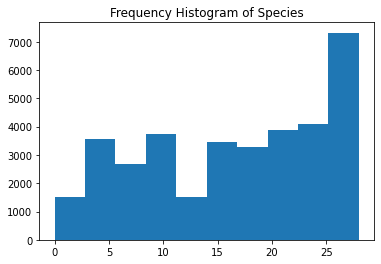

<Figure size 864x864 with 0 Axes>

In [ ]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

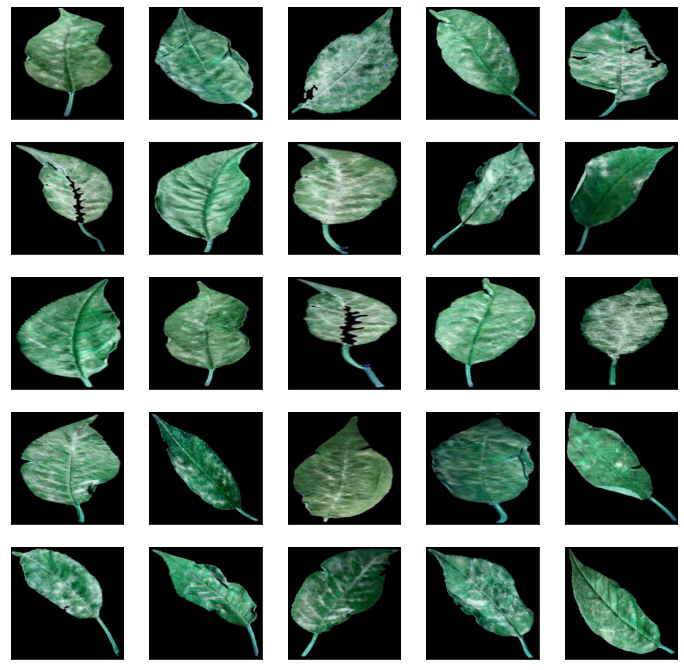

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Cherry_(including_sour)___Powdery_mildew', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

35036it [2:43:56,  3.56it/s]


Train Shape: (35036, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=29)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

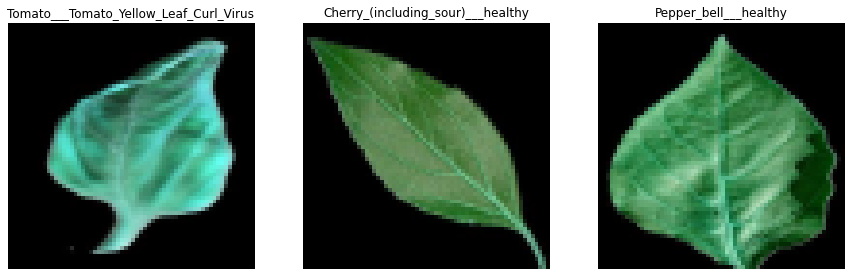

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)

    x = densenet(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(29,activation = 'softmax', name='root')(x)


    # model
    model = Model(input,output)

    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('PlantD5net.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
437/437 - 103s - loss: 2.5097 - accuracy: 0.3729 - val_loss: 1.3018 - val_accuracy: 0.5985

Epoch 00001: val_loss improved from inf to 1.30177, saving model to PlantD5net.h5
Epoch 2/50
437/437 - 50s - loss: 1.0053 - accuracy: 0.7005 - val_loss: 0.7151 - val_accuracy: 0.7711

Epoch 00002: val_loss improved from 1.30177 to 0.71507, saving model to PlantD5net.h5
Epoch 3/50
437/437 - 50s - loss: 0.6525 - accuracy: 0.7987 - val_loss: 0.4143 - val_accuracy: 0.8657

Epoch 00003: val_loss improved from 0.71507 to 0.41432, saving model to PlantD5net.h5
Epoch 4/50
437/437 - 50s - loss: 0.4769 - accuracy: 0.8531 - val_loss: 0.2858 - val_accuracy: 0.9117

Epoch 00004: val_loss improved from 0.41432 to 0.28583, saving model to PlantD5net.h5
Epoch 5/50
437/437 - 50s - loss: 0.3917 - accuracy: 0.8769 - val_loss: 0.3144 - val_accuracy: 0.9035

Epoch 00005: val_loss did not improve from 0.28583
Epoch 6/50
437/437 - 50s - loss: 0.3443 - accuracy: 0.8922 - val_loss: 0.6638 - val_accuracy: 0.81

In [ ]:
#model = load_model('../content/PlantD5net.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

219/219 [==============================] - 3s 16ms/step - loss: 0.1789 - accuracy: 0.9496
Final Loss: 0.17892171442508698, Final Accuracy: 0.949629008769989


Text(0.5, 144.41374999999996, 'Predicted')

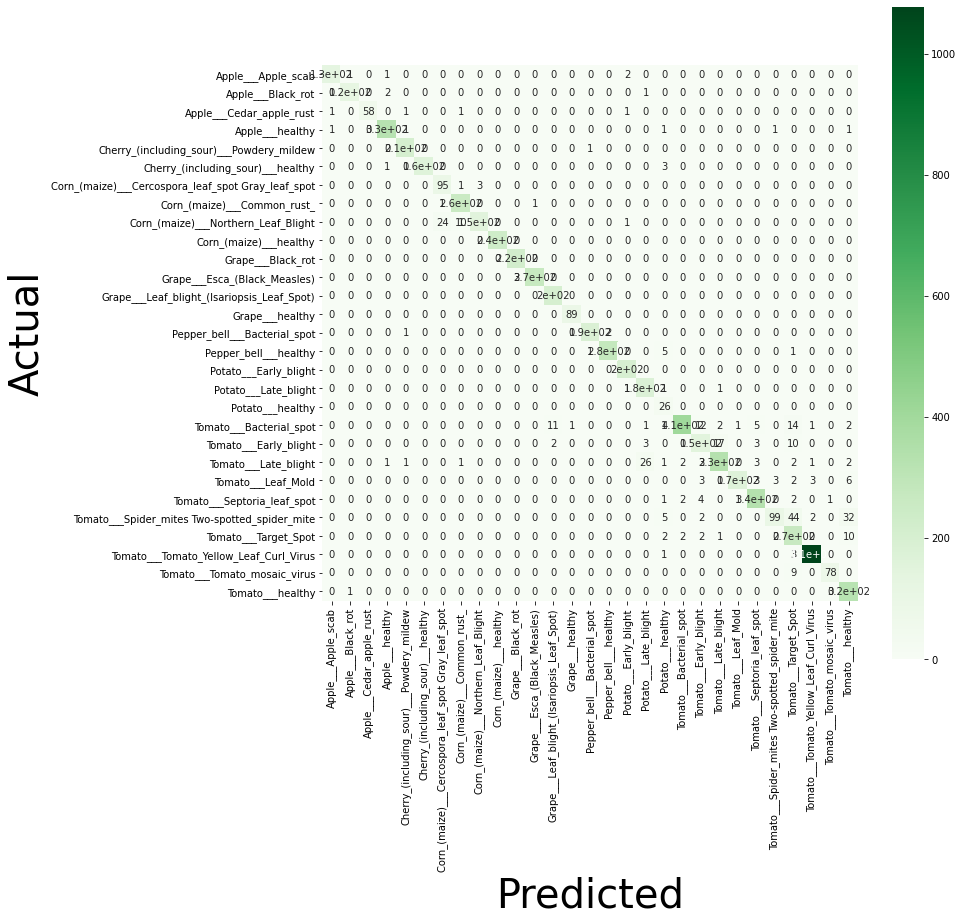

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

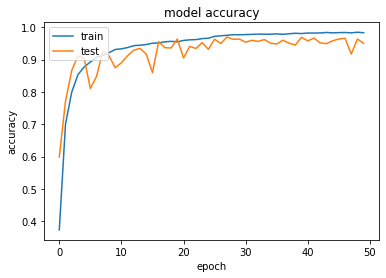

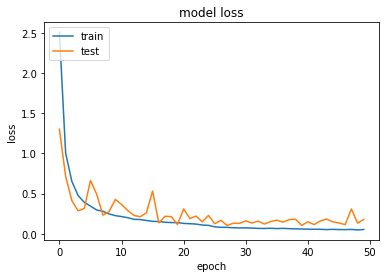

In [ ]:
# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()